

# Training a Classification Model for Imitiation Learning

We will be using this notebook to train a classification imitation learning model **on Google Colab**. Make sure to open this ipynb on Google Colab and hit connect in the top right menu to connect to the GPU.

In [6]:
import sys
sys.path.insert(0, '/home/de7281/MAE345/final_project')

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
data_dir = "/home/de7281/MAE345/final_project/drone/datasets/imitation_data"



Visualizing the data

state: {'x': 0.125214084982872, 'y': 0.04154543578624725, 'z': 0.5319483280181885, 'vx': 0.011366431601345539, 'vy': 0.020146576687693596, 'vz': 0.016029927879571915, 'roll': 0.320217490196228, 'pitch': -0.5104201436042786, 'yaw': -2.4912240505218506}
action: [0.2, 0.0, 0.0, 0.0]
(400, 640, 3)


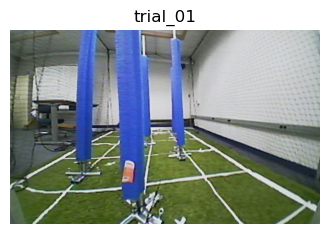

In [9]:
import cv2, matplotlib.pyplot as plt
from pathlib import Path
import json

trial0 = sorted([d for d in Path(data_dir).iterdir() if d.is_dir() and d.name.startswith("trial_")])[0]
e0 = json.load(open(trial0/"data_log.json"))[0]
img = cv2.cvtColor(cv2.imread(str(trial0 / e0["image_path"])), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off"); plt.title(trial0.name)
print("state:", e0["state"])
print("action:", e0["action"])
print(img.shape)

## Defining Dataloaders and Model Architecture

Here, you can import or copy over your model and dataloader. 
You should modify and optimize them for your final project to improve performance.

In [10]:
!pwd

/home/de7281/MAE345/final_project/drone/scripts


In [1]:
from omegaconf import OmegaConf

def load_config(config_path: str):
    """Load main config and merge with specified model config."""
    cfg = OmegaConf.load(config_path)
    
    # Load the model config based on model name
    model_name = cfg.model_name
    model_cfg_path = f"../configs/models/{model_name}.yaml"
    model_cfg = OmegaConf.load(model_cfg_path)
    
    # Merge model config into main config
    cfg.model = model_cfg
    
    return cfg

conf = load_config('../configs/train_config.yaml')

ConfigAttributeError: Missing key model_name
    full_key: model_name
    object_type=dict

In [5]:
from omegaconf import OmegaConf
cfg = OmegaConf.load('../configs/example_fly_config.yaml')
print(OmegaConf.to_yaml(cfg))
print("\nAvailable keys:", list(cfg.keys()))

defaults:
- models: discrete_action_model
ckpt_path: ../checkpoints/drone_control_model_classification.pth
data_dir: datasets/imitation_data
image_size:
- 224
- 224
augment: false
log_dir: recordings
group_number: 5
camera_id: 1
hover_height: 0.5
fly_steps: 100
crop_top: 80


Available keys: ['defaults', 'ckpt_path', 'data_dir', 'image_size', 'augment', 'log_dir', 'group_number', 'camera_id', 'hover_height', 'fly_steps', 'crop_top']


In [7]:
from drone.datasets.dataloader import create_dataloaders

In [8]:
train_dl, val_dl = create_dataloaders(
    data_dir=conf.dataset.data_dir,
    train_trials=conf.training.train_trials,
    val_trials=conf.training.val_trials,
    batch_size=conf.training.batch_size,
    image_size=conf.dataset.image_size,
    normalize_states=conf.dataset.normalize_states,
    normalize_actions=conf.dataset.normalize_actions,
    normalize_images=conf.dataset.normalize_images,
    num_workers=conf.training.num_workers,
    shuffle_train=conf.training.shuffle_train,
    augment=conf.dataset.augment
)

Auto-split: 12 train trials, 3 val trials
<class 'list'> [PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_01'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_02'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_03'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_04'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_05'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_06'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_07'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_08'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_09'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_data/trial_10'), PosixPath('/home/de7281/MAE345/final_project/drone/datasets/imitation_da

In [9]:
from drone.models.continuous_action_model import ContinuousActionModel
from drone.models.discrete_action_model import DiscreteActionModel

In [10]:
def initialize_model(cfg):
    name = cfg.model_name
    if name == "continuous_action_model":
        return ContinuousActionModel(
            cfg.model.pretrained,
            cfg.model.action_dim
        )
    elif name == "discrete_action_model":
        return DiscreteActionModel(
            cfg.model.pretrained,
            cfg.model.action_dim,
            cfg.model.num_bins,
            cfg.model.action_low,
            cfg.model.action_high
        )
    else:
        raise ValueError("Incorrect model specification")

In [11]:
model = initialize_model(conf)

## Training the model
Here, we load the dataset (which defaults to an 80/20 train–validation split), convert the continuous actions into discrete bins, and train the imitation learning model.

Make sure you are connected to GPU. This may take some time to train.

In [12]:
import torch
import torch.nn as nn

def loss_fn(outputs: torch.Tensor, labels: torch.Tensor, cfg) -> torch.Tensor:
    """
    Loss function to train the model with.
    
    :param outputs: model outputs
    :param labels: ground-truth labels (continuous actions for both cases)
    :param cfg: configuration object
    
    :return: computed loss
    """

    if cfg.model.output_space == 'discrete':
        # outputs: (B, action_dim, num_bins)
        # labels: (B, action_dim) continuous actions
        
        # Convert continuous labels to bin indices
        # Assuming you have access to the model to use continuous_to_bins
        # Or implement it here:
        clipped = labels.clamp(min=cfg.model.action_low, max=cfg.model.action_high)
        norm = (clipped - cfg.model.action_low) / (cfg.model.action_high - cfg.model.action_low)
        bin_labels = (norm * (cfg.model.num_bins - 1)).round().long()  # (B, action_dim)
        
        # Compute cross-entropy for each action dimension
        # Reshape: (B, action_dim, num_bins) -> (B*action_dim, num_bins)
        # and (B, action_dim) -> (B*action_dim)
        B, action_dim, num_bins = outputs.shape
        outputs_flat = outputs.reshape(B * action_dim, num_bins)
        labels_flat = bin_labels.reshape(B * action_dim)
        
        loss = nn.functional.cross_entropy(outputs_flat, labels_flat)
        return loss
    
    elif cfg.model.output_space == 'continuous':
        # outputs: (B, action_dim)
        # labels: (B, action_dim)
        
        loss = nn.functional.mse_loss(outputs, labels)
        return loss
    
    else:
        raise ValueError('Output Space not defined')


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
for batch in train_dl:
    b = batch
    break

In [15]:
print(b['observation'].shape)

torch.Size([32, 3, 224, 224])


In [ ]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=conf.training.lr)

# Track metrics
train_losses = []
val_losses = []

# training loop
for epoch in range(conf.training.num_epochs):
    # ============= Training Phase =============
    model.train()
    train_loss = 0.0
    train_batches = 0
    print("Hello")
    
    for batch in tqdm(train_dl, desc=f'Epoch {epoch+1}/{conf.training.num_epochs} [Train]'):
        # Move data to device
        print("got batch")
        images = batch['observation'].to(device)  # Adjust key name based on your dataloader
        actions = batch['action'].to(device)  # Ground truth actions
        
        print("got images and actions")
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        print("got outputs")
        
        # Compute loss
        loss = loss_fn(outputs, actions, conf)

        print("got loss")
        
        # Backward pass
        loss.backward()
        optimizer.step()

        print("stepped")
        
        # Track metrics
        train_loss += loss.item()
        train_batches += 1
    
    # Average training loss for this epoch
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # ============= Validation Phase =============
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for batch in tqdm(val_dl, desc=f'Epoch {epoch+1}/{conf.training.num_epochs} [Val]'):
            # Move data to device
            images = batch['image'].to(device)
            actions = batch['action'].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = loss_fn(outputs, actions, conf)
            
            # Track metrics
            val_loss += loss.item()
            val_batches += 1
    
    # Average validation loss for this epoch
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{conf.training.num_epochs} | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f}')

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

print(f'\n✅ Training complete!')
print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Val Loss: {val_losses[-1]:.4f}')


Hello


Epoch 1/1 [Train]:   0%|          | 0/126 [00:00<?, ?it/s]

got batch
got images and actions
got outputs
got loss


## Testing Model Inference


Here, we pick random samples from the validation set and prints both the model’s predicted actions and the ground-truth actions. View the sample images inside the `inference_samples` folder in the file-browser panel on the left.








In [ ]:
import cv2
import os

save_dir = "inference_samples"
os.makedirs(save_dir, exist_ok=True)

model.eval()
count = 0
num_samples = 5
with torch.no_grad():
    # TODO: implement testing/inference
    pass


## Saving the trained model.
You will need to **download** this model to your local crazyflie code directory in order to test on the drone. Click the folder icon on the left to download the model.

In [ ]:
SAVE_PATH = "/content/drone_control_model.pth" # TODO: change to prefered path
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Model saved to {SAVE_PATH}")